**IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import json
import re
import ast
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


**LOAD THE DATA**

In [2]:
movies_df = pd.read_csv('../../edit_data/Lee/cleaned_data/movies_main.csv')  
pd.set_option('display.max_columns', None)


In [3]:
movies_df.head(2)

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter']
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston']


**PREDICTION MODEL BASED ON POPULARITY AND ACTORS**

In [4]:
# Ensure 'Cast_parse' is in list format and handle any non-list or NaN entries
movies_df['Cast_parse'] = movies_df['Cast_parse'].apply(lambda x: eval(x) if isinstance(x, str) else x if isinstance(x, list) else [])

# Prompting the user to input an actor's name
actor_name = input("Enter the actor's name: ").strip().lower()

# Filtering movies based on the actor's name
filtered_movies = movies_df[movies_df['Cast_parse'].apply(lambda cast: any(actor_name == actor.lower().strip() for actor in cast))]

# Check if any movies match the actor
if filtered_movies.empty:
    print(f"No movies found with actor {actor_name}.")
else:
    # Sorting the filtered movies based on the 'Popularity' column in descending order
    filtered_movies_sorted = filtered_movies.sort_values(by='Popularity', ascending=False)

    # Selecting the top 5 movies
    top_5_filtered_movies = filtered_movies_sorted.head(5)

    # Formatting the output to look prettier
    print("\nTop 5 Movies featuring actor '{}':\n".format(actor_name.title()))
    for i, row in top_5_filtered_movies.iterrows():
        print(f"Title: {row['Original_Title']}")
        print(f"Vote Average: {row['Vote_Average']}")
        print(f"Popularity: {row['Popularity']}")
        print(f"Cast: {', '.join(row['Cast_parse'])}")
        print("-" * 50)  # Separator line for clarity



Top 5 Movies featuring actor 'Ryan Reynolds':

Title: Deadpool
Vote Average: 7.4
Popularity: 187.860492
Cast: Ryan Reynolds, Morena Baccarin, Ed Skrein, T.J. Miller, Gina Carano, Leslie Uggams, Brianna Hildebrand, Jed Rees, Stefan Kapičić, Randal Reeder, Isaac C. Singleton Jr., Michael Benyaer, Style Dayne, Kyle Cassie, Taylor Hickson, Ayzee, Naika Toussaint, Justyn Shippelt, Donna Yamamoto, Hugh Scott, Cindy Piper, Emily Haine, Aatash Amir, Chad Riley, Paul Belsito, Darcey Johnson, Kyle Rideout, Jason William Day, Stan Lee, Benjamin Wilkinson, Rachel Sheen, Paul Lazenby, Rob Hayter, Heather Ashley Chase, Fabiola Colmenero, Victoria De Mare, David Hardware, Matthew Hoglie, Tony Chris Kazoleas, Greg LaSalle, David Longworth, Michael Neumeyer, Sean Quan, Anthony J. Sacco, Olesia Shewchuk, Dan Zachary
--------------------------------------------------
Title: Life
Vote Average: 6.3
Popularity: 36.263803
Cast: Jake Gyllenhaal, Rebecca Ferguson, Ryan Reynolds, Hiroyuki Sanada, Ariyon Bakare

**KNN MODEL**

*TfidfVectorizer*: This is a tool from **sklearn** used for converting text data into numerical features. It transforms the textual information in the movie descriptions into a form that can be used by machine learning models.


*NearestNeighbors*: This is an algorithm from **sklearn** that helps in finding the nearest points (in this case, movies) based on some measure of distance. We use this for recommending similar movies.


Purpose: Movies have multiple text features (e.g., tagline, overview, and keywords) that describe them. To make the recommendation system more accurate, we combine these features into a single string that describes each movie.


In [7]:
# Combine relevant text features into a single string for vectorization
movies_df['combined_features'] = movies_df[['Tagline', 'Overview', 'Keywords_parse']].fillna('').agg(' '.join, axis=1)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Vectorize the combined features
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

# Initialize the Nearest Neighbors model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Fit the model using the TF-IDF matrix
knn.fit(tfidf_matrix)

# Function to get top 5 movie recommendations with additional details
def get_movie_recommendations(movie_title, model=knn, matrix=tfidf_matrix, data=movies_df):
    # Find the index of the input movie
    idx = data.index[data['Original_Title'].str.lower() == movie_title.lower()].tolist()
    
    if len(idx) == 0:
        return "Movie not found in the database."
    
    idx = idx[0]
    
    # Get the distances and indices of the nearest neighbors
    distances, indices = model.kneighbors(matrix[idx], n_neighbors=6)
    
    # Get the indices of the top 5 similar movies (excluding the input movie itself)
    similar_movies_indices = indices.flatten()[1:]
    
    # Fetch the details of the similar movies
    similar_movies = data.iloc[similar_movies_indices][['Original_Title', 'Popularity', 'Vote_Average', 'Original_Language']]
    
    return similar_movies

# Prompt the user for a movie title
user_input_movie = input("Enter a movie title: ")

# Get recommendations based on user input
recommendations = get_movie_recommendations(user_input_movie)

# Display the recommendations with additional details
if isinstance(recommendations, str):
    print(recommendations)
else:
    print("\nUser's Input: {}".format(user_input_movie))
    print("\nTop 5 movies similar to {}: \n".format(user_input_movie))
    for i, row in recommendations.iterrows():
        print("{}. {} (Popularity: {}, Rating: {}, Language: {})".format(i+1, row['Original_Title'], row['Popularity'], row['Vote_Average'], row['Original_Language']))



User's Input: rush hour 2

Top 5 movies similar to rush hour 2: 

13875. Paradise Canyon (Popularity: 1.334437, Rating: 3.7, Language: en)
2149. Rush Hour (Popularity: 11.840557, Rating: 6.8, Language: en)
1931. Herbie Goes Bananas (Popularity: 3.13734, Rating: 5.3, Language: en)
33469. Mit moon (Popularity: 2.753066, Rating: 4.6, Language: en)
11941. Rush Hour 3 (Popularity: 9.718111, Rating: 6.1, Language: en)


**WITH SIMILARITY SCORE**

**How Similarity Score is Calculated**

Movies similar to 'rush hour 2':
            Original_Title  Similarity_Score
13874      Paradise Canyon          0.271918
2148             Rush Hour          0.222315
1930   Herbie Goes Bananas          0.203236
33468             Mit moon          0.188912
11940          Rush Hour 3          0.171266


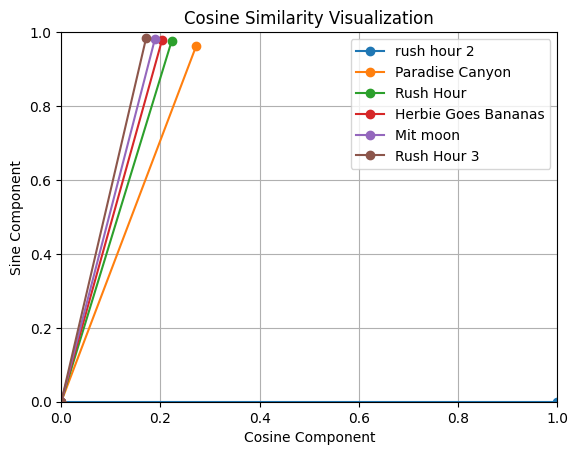

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Combine relevant text features into a single string for vectorization
movies_df['combined_features'] = movies_df[['Tagline', 'Overview', 'Keywords_parse']].fillna('').agg(' '.join, axis=1)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Vectorize the combined features
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

# Initialize the Nearest Neighbors model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Fit the model using the TF-IDF matrix
knn.fit(tfidf_matrix)

# Function to get top 5 movie recommendations with similarity scores
def get_movie_recommendations_with_similarity(movie_title, model=knn, matrix=tfidf_matrix, data=movies_df):
    idx = data.index[data['Original_Title'].str.lower() == movie_title.lower()].tolist()
    
    if len(idx) == 0:
        return "Movie not found in the database."
    
    idx = idx[0]
    
    distances, indices = model.kneighbors(matrix[idx], n_neighbors=6)
    
    similar_movies_indices = indices.flatten()[1:]
    similar_movies_distances = distances.flatten()[1:]
    
    similarity_scores = 1 - similar_movies_distances
    
    similar_movies = data.iloc[similar_movies_indices][['Original_Title']]
    similar_movies['Similarity_Score'] = similarity_scores
    
    return similar_movies

# Function to plot cosine similarity visualization
def plot_cosine_similarity(movie_title, recommendations_df):
    fig, ax = plt.subplots()

    base_similarity = 1.0
    movies = [movie_title] + recommendations_df['Original_Title'].tolist()
    similarities = [base_similarity] + recommendations_df['Similarity_Score'].tolist()

    # Convert similarity scores to angles for the plot (considering only the positive cosine similarities)
    angles = np.arccos(similarities)

    # Plot vectors for each movie, ensuring all vectors are in the positive quadrant
    for i, angle in enumerate(angles):
        x = np.cos(angle)
        y = np.sin(angle)
        ax.plot([0, x], [0, y], label=movies[i], marker='o')

    # Set axis limits to only show the positive quadrant (0 to 1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Cosine Component')
    ax.set_ylabel('Sine Component')
    ax.axhline(0, color='grey', lw=0.5)
    ax.axvline(0, color='grey', lw=0.5)

    # Title and legend
    ax.set_title('Cosine Similarity Visualization')
    ax.legend()

    plt.grid(True)
    plt.show()

# Example usage
user_input_movie = input("Enter a movie title: ")

recommendations = get_movie_recommendations_with_similarity(user_input_movie)

if isinstance(recommendations, str):
    print(recommendations)
else:
    print(f"Movies similar to '{user_input_movie}':")
    print(recommendations)
    plot_cosine_similarity(user_input_movie, recommendations)


In [19]:
# Assuming movies_old is already loaded as per your code
movies_old['poster_url'] = 'https://image.tmdb.org/t/p/original' + movies_old['poster_path'].astype(str)

# Extract only the relevant columns ('id' and 'poster_url')
poster_df = movies_old[['id', 'poster_url']]

# Ensure there are no duplicates in the poster_df based on 'id'
poster_df = poster_df.drop_duplicates(subset=['id'])

# Merge the poster_url into movies_df based on the 'id' column
movies_df = pd.merge(movies_df, poster_df, on='id', how='left')

# Display the updated DataFrame
movies_df.head()


,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse,combined_features,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,poster_url_x,poster_url_y,poster_url
0,862.0,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter'],"Led by Woody, Andy's toys live happily in his...",False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,https://image.tmdb.org/t/p/original/rhIRbceoE9...,https://image.tmdb.org/t/p/original/rhIRbceoE9...,https://image.tmdb.org/t/p/original/rhIRbceoE9...
1,8844.0,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston'],Roll the dice and unleash the excitement! When...,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,https://image.tmdb.org/t/p/original/vzmL6fP7aP...,https://image.tmdb.org/t/p/original/vzmL6fP7aP...,https://image.tmdb.org/t/p/original/vzmL6fP7aP...
2,15602.0,Grumpier Old Men,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,0.0,101.0,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,11.712900,6.5,92.0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","['Romance', 'Comedy']",['Grumpy Old Men Collec